# Initialization

In [76]:
import nltk
from nltk.corpus import words
import numpy as np

SEED = 42
NUM_ELEMENTS = 5000  # 100k elements in the stream
NUM_UNIQUE = 500  # 10k unique elements
NUM_RUNS = 25
NUM_SKETCHES = 20

# Set the seed for reproducibility
np.random.seed(SEED)

nltk.download('words')

word_list = words.words()

# Sample 10k distinct elements
unique_words = set(word_list)
distinct_elements = list(unique_words)[:NUM_UNIQUE]

# Generate the stream
stream = np.random.choice(distinct_elements, size=NUM_ELEMENTS)

# Shuffle the stream
np.random.shuffle(stream)

stream = np.array(stream)

print(f"Stream length: {len(stream)}")
print(f"Number of unique elements: {len(np.unique(stream))}")
print(f"First 10 elements of the stream: {stream[:10]}")

# Generate sketches
sketch_sizes = np.logspace(1, np.log10(NUM_ELEMENTS), num=NUM_SKETCHES, base=10, dtype=int)
print(f"Sketch sizes: {sketch_sizes}")

Stream length: 5000
Number of unique elements: 500
First 10 elements of the stream: ['amorphousness' 'earringed' 'Triphora' 'currant' 'klipdas' 'uncost'
 'triglot' 'bugology' 'remittance' 'capitular']
Sketch sizes: [  10   13   19   26   37   51   71   98  136  189  263  365  506  702
  974 1351 1874 2599 3605 4999]


[nltk_data] Downloading package words to
[nltk_data]     C:\Users\galno\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [77]:
from functools import lru_cache

@lru_cache(None)
def hash_fn(element, seed=0) -> float:
    key = (element, seed)
    return (hash(key) % 2**32) / 2**32

## Flajolet Martin

### Flajolet Martin - Alpha Version

In [78]:
def flajolet_martin(stream: np.ndarray) -> float:
    """
    Flajolet-Martin algorithm for counting distinct elements in a stream.
    :param stream: numpy array of elements
    :return: estimated number of distinct elements
    """
    hashed_stream = np.vectorize(hash_fn)(stream)
    return 1 / np.min(hashed_stream)

### Flajolet Martin - Beta Version

In [79]:
from typing import Optional

def flajolet_martin_beta(stream: np.ndarray, s: int, seeds: Optional[np.ndarray] = None) -> float:
    """
    Flajolet-Martin Beta algorithm for counting distinct elements in a stream.
    :param stream: numpy array of elements
    :param s: number of FM estimators to calculate
    :param seeds: numpy array of seeds for the hash functions
    :return: estimated number of distinct elements
    """
    seeds = np.arange(s) if seeds is None else seeds
    assert len(seeds) == s, "Number of seeds must match the number of FM estimators"
    
    Z = np.min(np.vectorize(hash_fn)(stream, np.array(seeds)[:, None]), axis=1)
    return 1 / np.mean(Z) - 1

### Flajolet Martin - Final Version

In [80]:
from concurrent.futures import ThreadPoolExecutor

def flajolet_martin_final(stream: np.ndarray, t: int, s: int) -> float:
    """
    Flajolet-Martin Final algorithm that uses t instances of Flajolet-Martin Beta.
    :param stream: numpy array of elements
    :param t: number of Flajolet-Martin Beta instances to run
    :param s: number of FM estimators per Flajolet-Martin Beta instance
    :return: median of the distinct element estimates
    """

    seed_sets = np.array_split(np.arange(t * s), t)

    with ThreadPoolExecutor() as executor:
        estimates = list(executor.map(
            lambda idx: flajolet_martin_beta(stream, s, seed_sets[idx]),
            range(t)
        ))    

    return np.median(estimates)

Run 25 times for each sketch size

In [ ]:
delta = 0.05  # 95% confidence interval

def process_sketch(sketch_size: int) -> tuple:
    """
    Process a single sketch size.
    :param sketch_size: size of the sketch
    :return: tuple of FM, FM-beta, and FM-final estimates
    """
    epsilon = np.sqrt(np.log(1 / delta) / sketch_size)  # So space complexity is O(log(1/delta)/epsilon^2)
    
    t = int(np.ceil(np.log(1 / delta)))
    s = int(np.ceil(1 / (epsilon**2)))
        
    print(f"Sketch size: {sketch_size}, epsilon: {epsilon:.2f}, t: {t}, s: {s}")
    
    fm_results = []
    fm_beta_results = []
    fm_final_results = []
    
    for _ in range(NUM_RUNS):
        # Generate sketch
        indices = np.random.choice(len(stream), size=sketch_size, replace=False)
        sketch = stream[indices]
        
        # Calculate FM, FM-beta, and FM-final estimates
        fm_estimate = flajolet_martin(sketch)
        fm_beta_estimate = flajolet_martin_beta(sketch, s)
        fm_final_estimate = flajolet_martin_final(sketch, t, s)
        
        fm_results.append(fm_estimate)
        fm_beta_results.append(fm_beta_estimate)
        fm_final_results.append(fm_final_estimate)
    
    print(f"Sketch size: {sketch_size}, FM estimate: {np.mean(fm_results):.2f}, FM-beta estimate: {np.mean(fm_beta_results):.2f}, FM-final estimate: {np.mean(fm_final_results):.2f}")
    return (fm_results, fm_beta_results, fm_final_results)

fm_results, fm_beta_results, fm_final_results = {}, {}, {}

true_unique = len(np.unique(stream))
print(f"True number of unique elements: {true_unique}")

results = [process_sketch(sketch_size) for sketch_size in sketch_sizes]

for i, sketch_size in enumerate(sketch_sizes):
    fm_results[sketch_size], fm_beta_results[sketch_size], fm_final_results[sketch_size] = results[i]

True number of unique elements: 500
Sketch size: 10, epsilon: 0.55, t: 3, s: 4
Sketch size: 10, FM estimate: 117.49, FM-beta estimate: 15.24, FM-final estimate: 11.40
Sketch size: 13, epsilon: 0.48, t: 3, s: 5
Sketch size: 13, FM estimate: 80.47, FM-beta estimate: 17.42, FM-final estimate: 14.02
Sketch size: 19, epsilon: 0.40, t: 3, s: 7
Sketch size: 19, FM estimate: 190.58, FM-beta estimate: 23.44, FM-final estimate: 22.50
Sketch size: 26, epsilon: 0.34, t: 3, s: 9
Sketch size: 26, FM estimate: 152.37, FM-beta estimate: 32.56, FM-final estimate: 29.39
Sketch size: 37, epsilon: 0.28, t: 3, s: 13
Sketch size: 37, FM estimate: 195.91, FM-beta estimate: 40.58, FM-final estimate: 39.04
Sketch size: 51, epsilon: 0.24, t: 3, s: 18
Sketch size: 51, FM estimate: 244.60, FM-beta estimate: 56.06, FM-final estimate: 49.88
Sketch size: 71, epsilon: 0.21, t: 3, s: 24
Sketch size: 71, FM estimate: 336.46, FM-beta estimate: 79.57, FM-final estimate: 70.66
Sketch size: 98, epsilon: 0.17, t: 3, s: 33
S

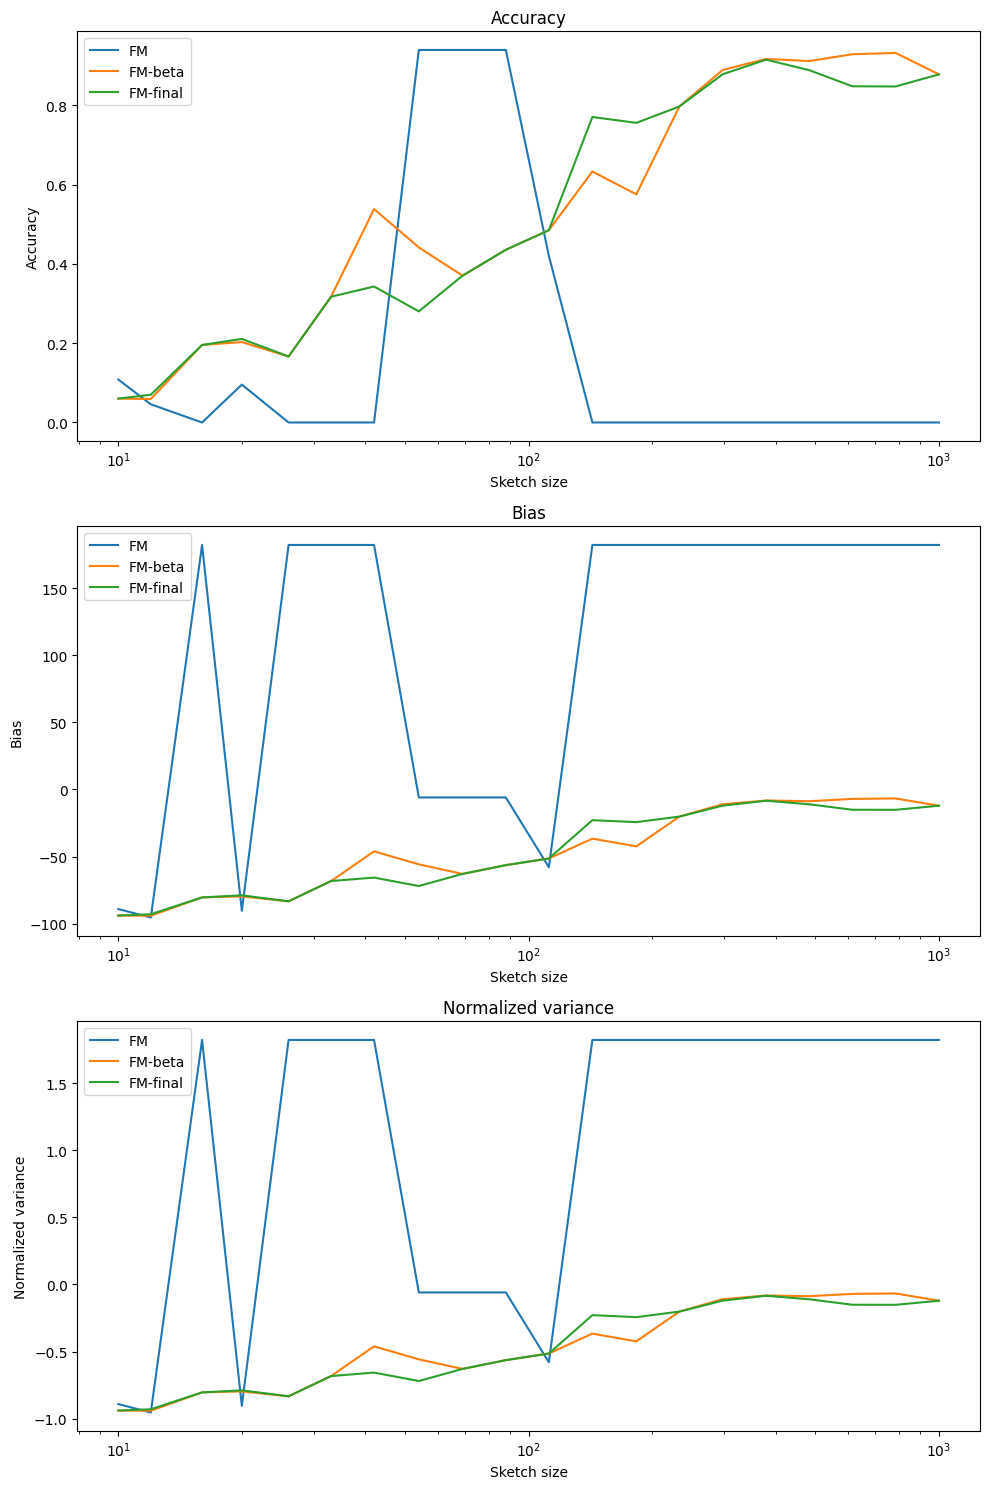

In [ ]:
import matplotlib.pyplot as plt

def calculate_metrics(estimates: dict) -> dict:
    """
    Calculate the accuracy, bias, and normalized variance of the estimates.
    :param estimates: dictionary of estimates
    :return: dictionary of metrics
    """
    metrics = {}
    for sketch_size, size_estimates in estimates.items():
        metrics[sketch_size] = {
            "accuracy": np.mean([max(0, 1 - abs(est - true_unique) / true_unique) for est in size_estimates]),
            "bias": np.mean([est - true_unique for est in size_estimates]),
            "normalized_variance": np.mean([((est - true_unique) / true_unique) for est in size_estimates])
        }
    return metrics

fm_metrics = calculate_metrics(fm_results)
fm_beta_metrics = calculate_metrics(fm_beta_results)
fm_final_metrics = calculate_metrics(fm_final_results)

# Create a figure and axis
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

# Plot the accuracy
ax[0].plot(sketch_sizes, [fm_metrics[sketch_size]["accuracy"] for sketch_size in sketch_sizes], label="FM")
ax[0].plot(sketch_sizes, [fm_beta_metrics[sketch_size]["accuracy"] for sketch_size in sketch_sizes], label="FM-beta")
ax[0].plot(sketch_sizes, [fm_final_metrics[sketch_size]["accuracy"] for sketch_size in sketch_sizes], label="FM-final")
ax[0].set_xscale("log")
ax[0].set_xlabel("Sketch size")
ax[0].set_ylabel("Accuracy")
ax[0].set_title("Accuracy")
ax[0].legend()

# Plot the bias
ax[1].plot(sketch_sizes, [fm_metrics[sketch_size]["bias"] for sketch_size in sketch_sizes], label="FM")
ax[1].plot(sketch_sizes, [fm_beta_metrics[sketch_size]["bias"] for sketch_size in sketch_sizes], label="FM-beta")
ax[1].plot(sketch_sizes, [fm_final_metrics[sketch_size]["bias"] for sketch_size in sketch_sizes], label="FM-final")
ax[1].set_xscale("log")
ax[1].set_xlabel("Sketch size")
ax[1].set_ylabel("Bias")
ax[1].set_title("Bias")
ax[1].legend()

# Plot the normalized variance
ax[2].plot(sketch_sizes, [fm_metrics[sketch_size]["normalized_variance"] for sketch_size in sketch_sizes], label="FM")
ax[2].plot(sketch_sizes, [fm_beta_metrics[sketch_size]["normalized_variance"] for sketch_size in sketch_sizes], label="FM-beta")
ax[2].plot(sketch_sizes, [fm_final_metrics[sketch_size]["normalized_variance"] for sketch_size in sketch_sizes], label="FM-final")
ax[2].set_xscale("log")
ax[2].set_xlabel("Sketch size")
ax[2].set_ylabel("Normalized variance")
ax[2].set_title("Normalized variance")
ax[2].legend()

plt.tight_layout()
plt.show()